## Setup

In [1]:
import pandas as pd
import numpy as np
import pickle
import xgboost as xgb
import matplotlib.pyplot as plt

## Load in Saved XGBoost Model & Data

In [2]:
# Load in trained model
bst = pickle.load(open("../3. ML/bst.pickle.dat", "rb"))

In [3]:
df = pd.read_csv('../data/formatted_mens.csv',header=0,parse_dates=["Date"])
df.dropna(inplace=True)

categorical_cols = ['Tournament', 'Court', 'Surface', 'Round', 'A', 'B']
df = pd.get_dummies(df,columns=categorical_cols,drop_first=True)

In [4]:
df[['Date','y']+bst.feature_names].sort_values(by='Date',inplace=True) #Match model feature labels

In [5]:
## Check we have no missing or extra features
print([c for c in df.columns if c not in bst.feature_names]) # Should be date & y
print([c for c in bst.feature_names if c not in df.columns]) # Should be empty

['Date', 'y']
[]


In [6]:
split_time = pd.to_datetime('2018-01-01') # SAME SPLIT FROM ML EXPLORING
df = df.loc[df['Date']>=split_time]

## Make Predictions

In [7]:
d = xgb.DMatrix(df.drop(columns=['Date','y']), label=df['y'])
df['prediction'] = bst.predict(d)

In [8]:
df['betting_direction'] = (df['prediction'] > 0.5).astype('uint8')
df['correct'] = df['betting_direction'] == df['y']
df

,Date,A_rank,B_rank,APts,BPts,A_Max,B_Max,A_Avg,B_Avg,A_hist_form,...,B_Zhang Ze,B_Zhang Zh.,B_Ziadi M.,B_Zopp J.,B_Zverev A.,B_Zverev A.,B_Zverev M.,prediction,betting_direction,correct
44664,2018-01-01,47.0,52.0,1010.0,909.0,1.75,2.35,1.67,2.17,0.50,...,0,0,0,0,0,0,0,0.479442,0,False
44665,2018-01-01,79.0,76.0,662.0,670.0,1.65,2.52,1.58,2.37,0.50,...,0,0,0,0,0,0,0,0.550349,1,False
44666,2018-01-01,33.0,218.0,1302.0,235.0,1.57,3.00,1.44,2.73,0.50,...,0,0,0,0,0,0,0,0.562842,1,True
44667,2018-01-01,66.0,120.0,768.0,498.0,2.38,1.75,2.20,1.66,0.50,...,0,0,0,0,0,0,0,0.466555,0,False
44668,2018-01-01,54.0,94.0,890.0,593.0,2.00,2.02,1.89,1.89,0.50,...,0,0,0,0,0,0,0,0.492308,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50582,2020-11-20,7.0,1.0,5525.0,11830.0,3.92,1.35,3.52,1.31,0.40,...,0,0,0,0,0,0,0,0.386082,0,True
50583,2020-11-20,4.0,9.0,6970.0,3455.0,1.40,4.00,1.29,3.60,1.00,...,0,0,0,0,0,0,0,0.631394,1,True
50584,2020-11-21,1.0,3.0,11830.0,9125.0,1.66,2.70,1.56,2.47,0.70,...,0,0,0,0,0,0,0,0.515499,1,False
50585,2020-11-21,4.0,2.0,6970.0,9850.0,1.95,2.20,1.80,2.04,0.00,...,0,0,0,0,0,0,0,0.519724,1,True


## Hedging Strategy

Given a prediction which we have p confidence in, how much should we hedge? Well betting $\frac{\alpha}{\alpha+\beta}$ will give $\mathbb{E}\left[returns\right]=0$ and var(returns)=0. So we should hedge $h \in [0,\frac{\alpha}{\alpha+\beta}]$

In [9]:
hedge_coefficient = 2
def hedge_amount(alpha,beta,p):
    if p < 0.5:
        return hedge_amount(beta,alpha,1-p)
    else:
        return max(alpha/(alpha+beta) * (1-(2*p-1)**hedge_coefficient),0.35)
    
hedge_amount_vectorized = np.vectorize(hedge_amount)

Text(0, 0.5, 'h')

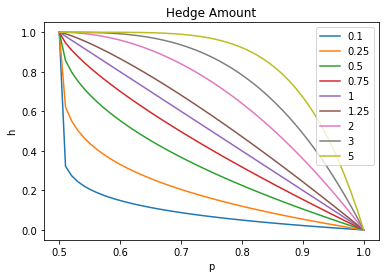

In [10]:
for h_coeff in [0.1,0.25,0.5,0.75,1,1.25,2,3,5]:
    x = np.linspace(0.5,1)
    y = 1-(2*x-1)**h_coeff
    plt.plot(x,y,label=h_coeff)
plt.legend()
plt.title("Hedge Amount")
plt.xlabel('p')
plt.ylabel('h')

In [11]:
df['h'] = hedge_amount_vectorized(df['A_Max'],df['B_Max'],df['prediction'])

Text(0.5, 1.0, 'Hedge Proportion')

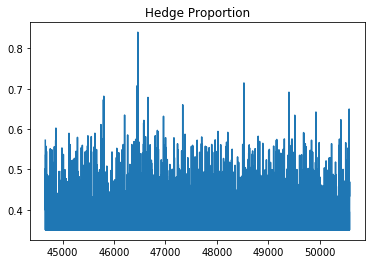

In [12]:
plt.plot(df['h'])
plt.title("Hedge Proportion")

## Calculating Expectation, Variance & P/L

In [13]:
def expected_return(alpha,beta,p,h):
    if p<0.5:
        return expected_return(beta,alpha,1-p,h)
    else:
        return alpha*(1-h)*p + beta*h*(1-p)
    
expected_return_vectorised = np.vectorize(expected_return)

def var_returns(alpha,beta,p,h):
    if p<0.5:
        return var_returns(beta,alpha,1-p,h)
    else:
        return p*(1-p)*(alpha*h-alpha+beta*h)**2
    
var_returns_vectorised = np.vectorize(var_returns)

In [14]:
df['E'] = expected_return_vectorised(df['A_Max'],df['B_Max'],df['prediction'],df['h'])
df['E_no_hedge'] = expected_return_vectorised(df['A_Max'],df['B_Max'],df['prediction'],0)
df['var'] = var_returns_vectorised(df['A_Max'],df['B_Max'],df['prediction'],df['h'])
df['var_no_hedge'] = var_returns_vectorised(df['A_Max'],df['B_Max'],df['prediction'],0)

Text(0.5, 1.0, 'Expected Returns')

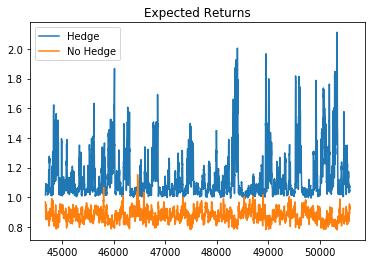

In [15]:
plt.plot(df['E'].rolling(10).mean(),label='Hedge')
plt.plot(df['E_no_hedge'].rolling(10).mean(),label='No Hedge')
plt.legend()
plt.title("Expected Returns")

Text(0.5, 1.0, 'Var of Returns')

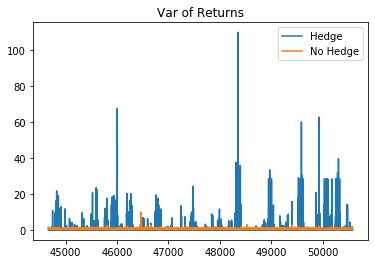

In [16]:
plt.plot(df['var'],label='Hedge')
plt.plot(df['var_no_hedge'],label='No Hedge')
plt.legend()
plt.title('Var of Returns')

This shows we shouldn't bet on everything!! As have some E < 0.<br>
We should hedge, look at how much hedging reduces returns

In [17]:
def actual_return_or_loss(alpha,beta,p,h):
    if p<0.5:
        return actual_return_or_loss(beta,alpha,1-p,h)
    else:
        return alpha*(1-h),beta*h
    
actual_return_or_loss_vectorised = np.vectorize(actual_return_or_loss)

In [18]:
df['return_if_correct'],df['loss_if_incorrect'] = actual_return_or_loss_vectorised(df['A_Max'],df['B_Max'],df['prediction'],df['h'])

## Deciding When To Bet

In [19]:
def should_we_bet(alpha,beta,p):
    if p < 0.5:
        return 1/beta < 1-p
    else:
        return 1/alpha < p
    
should_we_bet_vectorised = np.vectorize(should_we_bet)

In [20]:
df['make_bet_max'] = should_we_bet_vectorised(df['A_Max'],df['B_Max'],df['prediction'])
df['make_bet_avg'] = should_we_bet_vectorised(df['A_Avg'],df['B_Avg'],df['prediction'])

#### E & Var When We Should Bet

Text(0.5, 1.0, 'Expected Returns (when we should bet)')

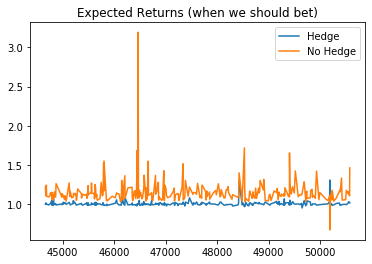

In [21]:
plt.plot(df[df['make_bet_avg']]['E'],label='Hedge')
plt.plot(df[df['make_bet_avg']]['E_no_hedge'],label='No Hedge')
plt.legend()
plt.title("Expected Returns (when we should bet)")

Text(0.5, 1.0, 'Var of Returns (when we should bet)')

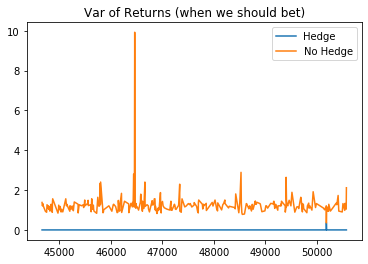

In [22]:
plt.plot(df[df['make_bet_avg']]['var'],label='Hedge')
plt.plot(df[df['make_bet_avg']]['var_no_hedge'],label='No Hedge')
plt.legend()
plt.title('Var of Returns (when we should bet)')

## Backtesting The Model

Firstly let's let the model predict everything now, so it's quicker!

In [23]:
cash = 1
bets_df = pd.DataFrame(data=[],columns = ['date','cash_start','cash_end','n_bets_made','n_bets_won','return'])
bets_df = bets_df.set_index('date')

In [24]:
def make_bets(bets_to_make,cash):
    weights = bets_to_make['E']-10*bets_to_make['var']
    weights = weights/weights.sum()
    
    returns = np.where(bets_to_make.correct,bets_to_make.return_if_correct,bets_to_make.loss_if_incorrect)
    weighted_returns = weights * returns
    actual_return = weighted_returns.sum()
    
    n_bets_made = bets_to_make.shape[0]
    n_bets_won = bets_to_make['correct'].sum()
    
    return n_bets_made,n_bets_won,cash*actual_return,100*(actual_return-1)

In [25]:
for date,frame in df.groupby('Date',as_index=False):
    bets_to_make = frame.loc[frame['make_bet_max'],:]

    if cash <=0 :
        print("Out of money!")
        break
    elif bets_to_make.shape[0]<1:
        continue
    else:
        n_bets_made,n_bets_won,new_cash,percent_return = make_bets(bets_to_make,cash)
        bets_df.loc[date,:] = [cash,new_cash,n_bets_made,n_bets_won,percent_return]
        cash = new_cash

## Strategy Analysis

In [26]:
total_bets_made = bets_df['n_bets_made'].sum()
total_bets_won = bets_df['n_bets_won'].sum()

print("We won ",round(100*total_bets_won/total_bets_made),"% of ",total_bets_made," bets made")

We won  54.0 % of  646  bets made


In [27]:
bets_df

,cash_start,cash_end,n_bets_made,n_bets_won,return
date,,,,,
2018-01-01,1,1.00305,2,0,0.30465
2018-01-02,1.00305,1.01982,4,1,1.67211
2018-01-04,1.01982,1.02295,1,0,0.307091
2018-01-05,1.02295,1.04472,2,1,2.12783
2018-01-06,1.04472,1.04681,1,1,0.200052
...,...,...,...,...,...
2020-11-08,98.6354,97.9527,1,0,-0.692081
2020-11-09,97.9527,101.221,1,0,3.33673
2020-11-15,101.221,103.308,1,0,2.06183


Text(0.5, 1.0, 'Wallet Over Time')

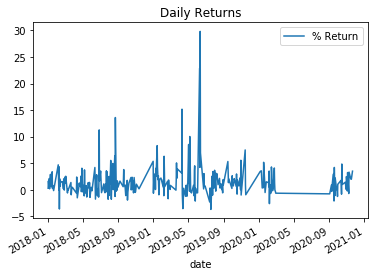

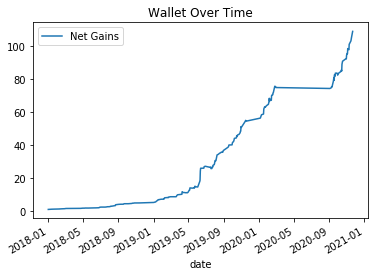

In [28]:
bets_df.plot(y='return',label='% Return')
plt.title("Daily Returns")
bets_df.plot(y='cash_end',label='Net Gains')
plt.title("Wallet Over Time")

In [30]:
bets_df['return'].std()

2.9613494837267362